In [20]:
from tsputil import *
from gurobipy import *
from itertools import chain, combinations # For the powerset

%run ./tsputil.py 
%matplotlib inline

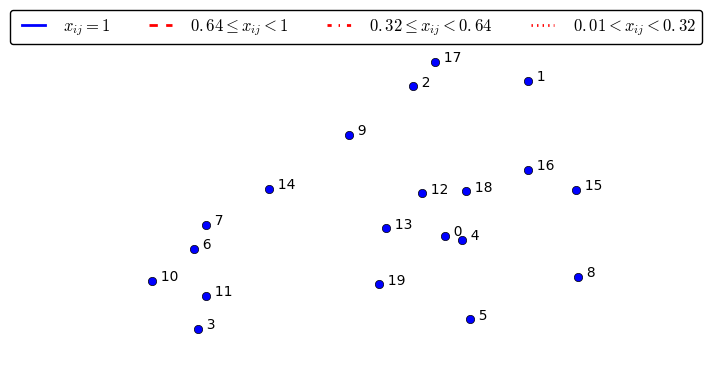

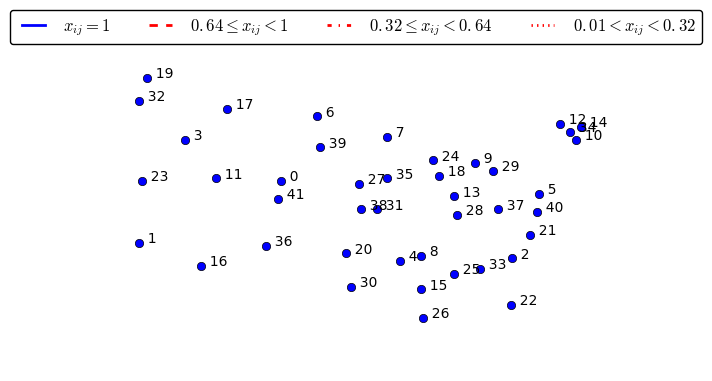

In [21]:
ran_points = Cities(n = 20, seed = "another different seed")
plot_situation(ran_points)

dantzig42 = read_instance("dantzig42.dat")
plot_situation(dantzig42)


# Task 1

In [22]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def Edges(vertices):
    """Takes a set of vertices and returns a set of edges from those vertices. 
    Also edges should be ordered by ij if i < j or ji if j < i"""
    # Every vertex is connected to each other, so therefore we can construct the edges like this
    E = [(i,j) for i in vertices for j in vertices if i<j]
    return E

def delta(v, V):
    """The set of edges in the cut (v, V∖{v})"""
    E = [(i,j) for i in v for j in V if i<j]
    D = [(j,i) for i in v for j in V if j<i]
    return E+D

def solve_tsp(points, subtours = []):
    points=list(points)
    V = range(len(points))
    E = [(i,j) for i in V for j in V if i<j]
    E = tuplelist(E)

    m = Model("TSP0")
    m.setParam(GRB.param.Presolve, 0)
    m.setParam(GRB.param.Method, 0)
    m.setParam(GRB.param.MIPGap,1e-7)

    ######### BEGIN: Write here your model for Task 1   

    # Decision Variables
    tmp = []
    
    roads = {}
    for (a,b) in E:
        road = m.addVar(lb=0, ub=1, vtype=GRB.BINARY, name="road"+str((a,b)))
        roads[(a,b)] = road
        tmp += [road * distance(points[a], points[b])]

    # Set the objective function
    m.setObjective( quicksum(tmp), GRB.MINIMIZE )
      
    # Constraint to make sure we have exactly 2 roads for each city
    for i in V:
        m.addConstr( quicksum( roads[(a,b)] for (a,b) in delta([i], V) ), GRB.EQUAL, 2, name="c1_"+str(i)+str((a,b)))
    
    # Constraint to remove subtours
    for i in subtours:
        if len(i) < 2:
            continue
        m.addConstr( quicksum( roads[(a,b)] for (a,b) in Edges(i)) <= len(i) - 1 )
    
    ######### END
    
    m.optimize()
    m.write("tsplp.lp")
    
    if m.status == GRB.status.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)
        m.write("tsplp.sol") # write the solution
        #for (a,b) in E:
        #    if roads[(a,b)].x == 1.0:
        #        plt.plot([points[a].real, points[b].real],[points[b].imag, points[b].imag], "k-")
        return {(i,j) : roads[(i,j)].x for i,j in E}
    else:
        print "Something wrong in solve_tsplp"
        exit(0)

# Creating the subset of cities
sets = list(powerset(range(len(ran_points))))
# The first element of the list is the empty set and the last element is the full set, hence we remove them.
sets = sets[1:(len(sets)-1)]
solve_tsp(ran_points, sets) Don't solve

SyntaxError: invalid syntax (<ipython-input-22-b3f5bfe57ae2>, line 74)

# Task 2

In [ ]:
def solve_tsp0(points, subtours = []):
    points=list(points)
    V = range(len(points))
    E = [(i,j) for i in V for j in V if i<j]
    E = tuplelist(E)

    m = Model("TSP0")
    m.setParam(GRB.param.Presolve, 0)
    m.setParam(GRB.param.Method, 0)
    m.setParam(GRB.param.MIPGap,1e-7)

    ######### BEGIN: Write here your model for Task 1   

    # Decision Variables
    tmp = []
    
    roads = {}
    for (a,b) in E:
        road = m.addVar(lb=0, ub=1, vtype=GRB.INTEGER, name="road_" "(" + str(a) + ", " + str(b) + ")")
        roads[(a,b)] = road
        tmp += [road * distance(points[a], points[b])]

    # Set the objective function
    m.setObjective( quicksum(tmp), GRB.MINIMIZE )
      
    # Constraint to make sure we have exactly 2 roads for each city
    for i in V:
        m.addConstr( quicksum( roads[(a,b)] for (a,b) in delta([i], V) ), GRB.EQUAL, 2, name="c1_" + str(i) + "(" + str(a) + ", " + str(b) + ")" )
    
    # Constraint to remove subtours
    for i in subtours:
        if len(i) < 2:
            continue
        m.addConstr( quicksum( roads[(a,b)] for (a,b) in Edges(i)) <= len(i) - 1 )
    
    ######### END
    
    m.optimize()
    m.write("tsplp.lp")
    
    if m.status == GRB.status.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)
        m.write("tsplp.sol") # write the solution
        #for (a,b) in E:
        #    if roads[(a,b)].x == 1.0:
        #        plt.plot([points[a].real, points[b].real],[points[b].imag, points[b].imag], "k-")
        return {(i,j) : roads[(i,j)].x for i,j in E}
    else:
        print "Something wrong in solve_tsplp"
        exit(0)


tsplp0 = solve_tsp0(ran_points, [])
plot_situation(ran_points, tsplp0)

Not all variables are integer. The matrix is not TUM since some variables are in between 0 and 1. No. Since we removed the constraint that removes subtours, we can expext subtours to occur.

# Task 3

In [ ]:
tsplp1 = solve_tsp0(ran_points, [(3,10,11),(3,6,10,11),(3,6,7,10,11),(0,4,18),(0,4,12,18),(3,6,7,10,11,14)])
plot_situation(ran_points, tsplp1)

# Task 4

Objective function:
$$ \max \sum_{e=ij\in E':i < j} x^*_e y_e - \sum_{i \in V' \setminus \{k\}} z_i $$
Constraints:
$$ z_k = 1 $$
$$ y_{ij} \geq z_i + z_j - 1 \quad \forall ij \in E' $$
$$ y_{ij} \leq z_i,z_j \quad \forall ij \in E' $$
$$ y_{ij} \geq 0 \quad \forall ij \in E' $$
$$ z \in \mathbb{B}^n $$

# Task 5

In [23]:
def solve_separation(points, x_star, k):
    points=list(points)
    V = range(len(points))
    Vprime = range(1,len(points))
    E = [(i,j) for i in V for j in V if i<j]
    Eprime = [(i,j) for i in Vprime for j in Vprime if i<j]
    E = tuplelist(E)
    Eprime = tuplelist(Eprime)

    m = Model("SEP")
    m.setParam(GRB.param.OutputFlag,0)
    
    ######### BEGIN: Write here your model for Task 4

    # Decision variables
    z_values = {}
    right_objective = []
    for i in Vprime:
        z_values[i] = m.addVar(lb = 0, ub = 1, vtype = GRB.INTEGER, name = "z_" + str(i))
        if i != k:
            right_objective += [z_values[i]]
    
    y_values = {}
    left_objective = []
    for (i, j) in Eprime:
        if i < j:
            y_values[(i, j)] = m.addVar(lb = 0, ub = 1, vtype = GRB.INTEGER, name = "y_" + str((i, j)))
            left_objective += [x_star[(i, j)] * y_values[(i, j)]]
    
    m.setObjective(quicksum(left_objective) - quicksum(right_objective), GRB.MAXIMIZE)
    
    # Add constraints
    
    m.addConstr(z_values[k] == 1)
    
    for (i, j) in Eprime:
        m.addConstr(y_values[(i, j)] >= z_values[i] + z_values[j] - 1)
        m.addConstr(y_values[(i, j)] <= z_values[i])
        m.addConstr(y_values[(i, j)] <= z_values[j])
            
    
    ######### END
    m.optimize()
    #m.write("sep.lp")
    
    if m.status == GRB.status.OPTIMAL:
        print('Separation problem solved for k=%d, solution value %g' % (k,m.objVal))
        #m.write("sep.sol") # write the solution    
        subtour = filter(lambda i: z_values[i].x>=0.99, z_values)
        return m.objVal, subtour
    else:
        print "Something wrong in solve_tsplp"
        exit(0)

In [28]:
for k in range(1,20):
    solve_separation(ran_points, tsplp0, k)

Separation problem solved for k=1, solution value 1
Separation problem solved for k=2, solution value 1
Separation problem solved for k=3, solution value 1
Separation problem solved for k=4, solution value -0
Separation problem solved for k=5, solution value 1
Separation problem solved for k=6, solution value 1
Separation problem solved for k=7, solution value 1
Separation problem solved for k=8, solution value 1
Separation problem solved for k=9, solution value 1
Separation problem solved for k=10, solution value 1
Separation problem solved for k=11, solution value 1
Separation problem solved for k=12, solution value 1
Separation problem solved for k=13, solution value 1
Separation problem solved for k=14, solution value 1
Separation problem solved for k=15, solution value 1
Separation problem solved for k=16, solution value 1
Separation problem solved for k=17, solution value 1
Separation problem solved for k=18, solution value -0
Separation problem solved for k=19, solution value 1


# Task 6

In [ ]:
def cutting_plane_alg(points):
    Vprime = range(1,len(points))
    subtours = []
    found = True
    while found:
        lpsol = solve_tsp0(points,subtours)
        # plot_situation(points, lpsol)
        found = False
        tmp_subtours = []
        best_val = float('-inf')
        for k in Vprime:
            value, subtour = solve_separation(points,lpsol,k)
            best_val = value if value > best_val else best_val
            ######### BEGIN: write here the condition. Include a tollerance
            if value > 0.49: 
            ######### END
                found = True
                tmp_subtours += [subtour]
        subtours += tmp_subtours
        print '*'*60
        print "********** Subtours found: ",tmp_subtours," with best value : ",best_val
        print '*'*60
    plot_situation(points, lpsol)

In [ ]:
cutting_plane_alg(dantzig42)

If we run our random seed with continuous variables, we find a solution. If we run the dantzig42 with continuous variables, we do not get a solution, but if we use integer variables, we get a solution. 

# Task 9

Tour length: 2652,2

Questions: 

Task 2: Skal vi beholde integrality constraint? Opgaven siger vi skal fjerne den, men det lød som om Marco sagde man kunne prøve at fjerne den, men man egentligt ikke skulle.

Er task 4 korrekt?

Task 5: Hvad betyder objective value for vores seperation problem? For k?

Task 6: Hvad betyder sætningen "add the condition for the presence of violated inequalities." og "Include a tollerance"?


